## Get firing field of selected neuron using behavioral trajectory and processed 2P data from suite2p

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from utils_analysis import plot_trajectory, getTuningMap, getLinearSpeed

### 1, get the trajectory

In [2]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
filenamelist = ["00004", "00005", "00006", "00007", "00008", "00009", "00010", "00012", "00014", "00016", "00017", "00018"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX = trajectory[0]
    allZ = trajectory[1]
    allTime = trajectory[2]
else:
    allX, allZ, allTime, fig = plot_trajectory(datafolder, filenamelist)

#chnage allX and allZ from dictionary to np.array
Traj_x = np.concatenate(list(allX.values()))
Traj_z = np.concatenate(list(allZ.values()))
#normalize x and z to [0,1]
Traj_x = (Traj_x-np.min(Traj_x))/(np.max(Traj_x)-np.min(Traj_x))
Traj_z = (Traj_z-np.min(Traj_z))/(np.max(Traj_z)-np.min(Traj_z))

#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime)):
    #chnage allTime[i] to np.array
    allTime[i] = np.array(allTime[i])
    if i == 0:
        timestamps = allTime[i]
    else:
        timestamps = np.concatenate((timestamps, allTime[i]+timestamps[-1]+0.033))

#### plot the speed

Text(0, 0.5, 'Speed (m/s)')

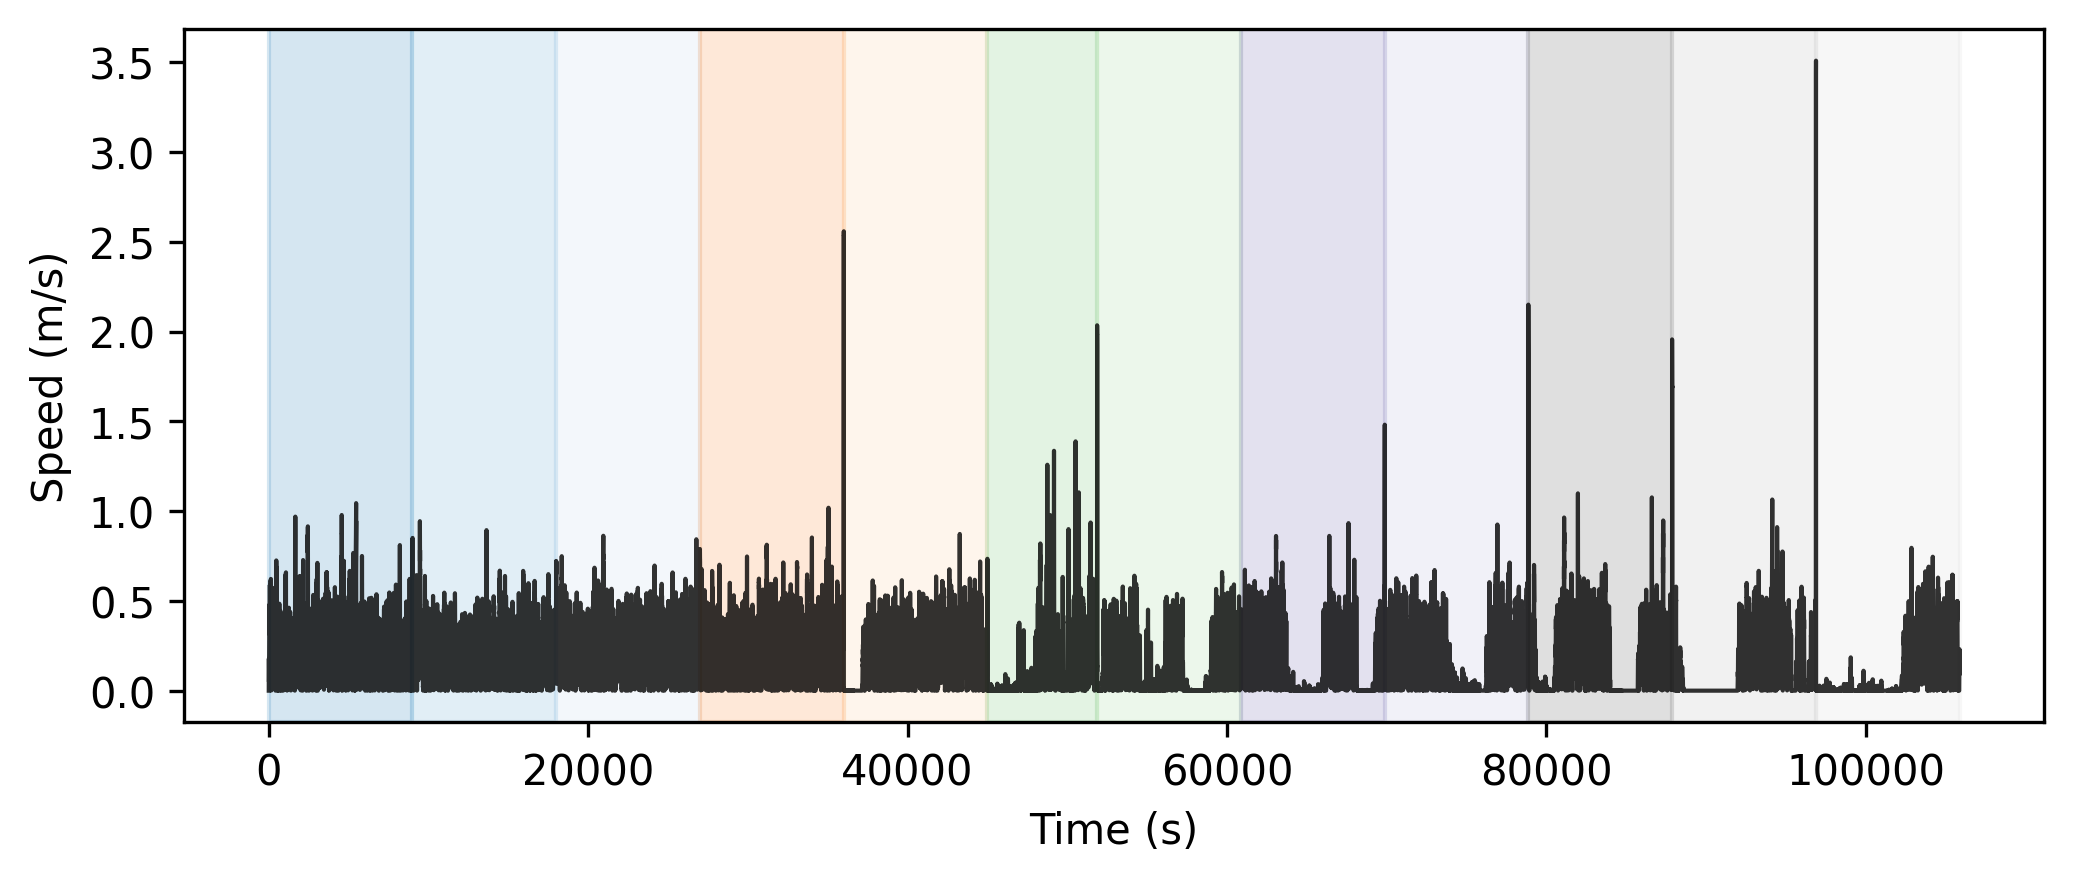

In [3]:
#plot the speed
speed = getLinearSpeed(Traj_x, Traj_z, timestamps, boxcar_size=5)

plt.figure(figsize=(8, 3), dpi=300)

#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))

plt.plot(speed, linewidth=1, color='k', alpha=0.8)

#add horizonatal lines with different colors to mark different sessions
split_ind = np.cumsum([len(allTime[i]) for i in range(len(allTime))])
#add 0 at the beginning 
split_ind = np.concatenate(([0], split_ind))
for i in range(len(allTime)):
    #plt.plot([split_ind[i], split_ind[i+1]], [3, 3], color=colors[i], linewidth=2, alpha=1)
    #using shaded region to mark different sessions
    plt.axvspan(split_ind[i], split_ind[i+1], alpha=0.2, color=colors[i])

#xlabel and ylabel  
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')

### 2, get suite2p outputs and plot one firing rate map

In [4]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)

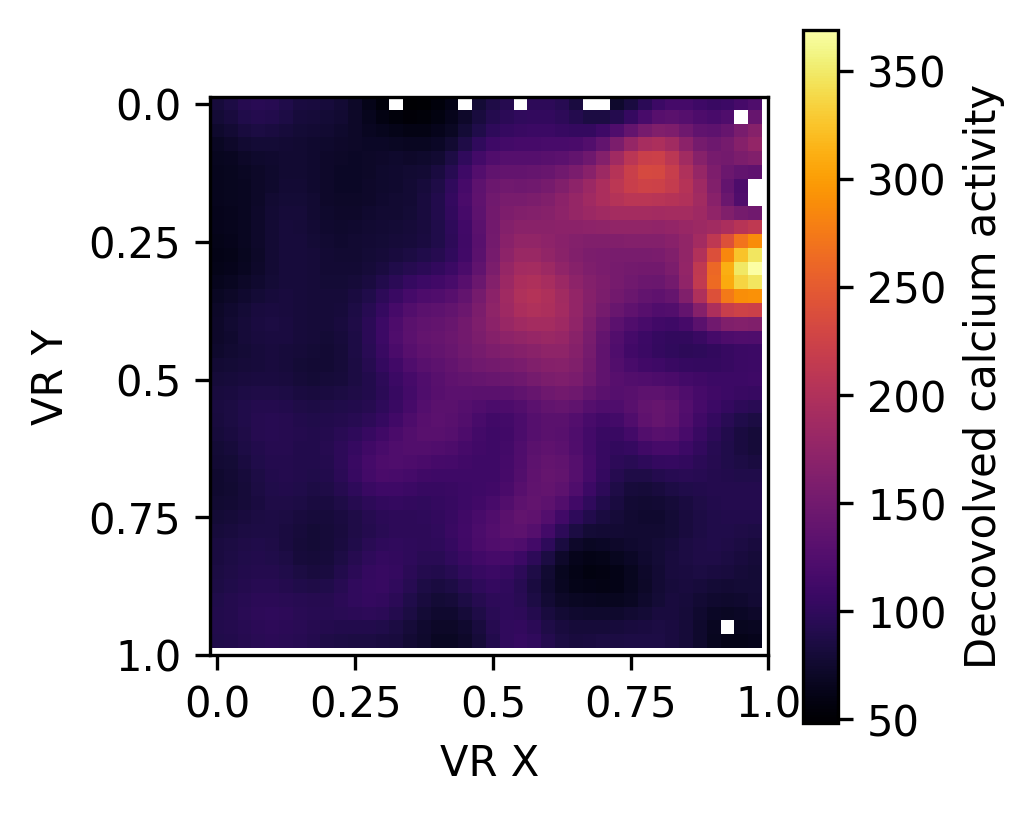

In [5]:
ind = 0
map = getTuningMap(spks[ind], Traj_x, Traj_z, timestamps, VRsize=(1,1), 
                   binsize=(0.025,0.025), sigma=5/2.5, speed_thres=0.025, 
                   boxcar_size=5, visit_thres=0.1,
                   cell_id=ind, datafolder=datafolder)
plt.figure(figsize=(3, 3), dpi=300)
#imshow the map
plt.imshow(map, cmap='inferno')
#xlabel and ylabel
plt.xlabel('VR X')
plt.ylabel('VR Y')
#set xticks and yticks from 0 to map.shape[0], but relabel them as 0 to 1
plt.xticks(np.linspace(0, map.shape[0], 5), np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, map.shape[1], 5), np.linspace(0, 1, 5))
#add colorbar and label
plt.colorbar(label='Decovolved calcium activity')

### 3, plot all firing fields of all neurons with peak deconvolved calcium activity > 100

In [6]:
#also get the index
cell_idx = np.where(iscell[:,0]==1)[0]
peak_thres = 100

#for each neuron, calculate the tuning map
all_maps = {}
for i in cell_idx:
    print('Getting tuning map of cell '+str(i))
    map = getTuningMap(spks[i], Traj_x, Traj_z, timestamps, 
                       VRsize=(1,1), binsize=(0.025,0.025), sigma=3, 
                       speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                       peak_thres=peak_thres, cell_id=i, datafolder=datafolder)
    all_maps[i] = map

#for elemnts in all_maps, filter out the ones with peak value < peak_thres
valid_maps = {k: v for k, v in all_maps.items() if np.nanmax(v)>peak_thres}


Getting tuning map of cell 0
Getting tuning map of cell 1
Getting tuning map of cell 2
Getting tuning map of cell 3
Getting tuning map of cell 4
Getting tuning map of cell 5
Getting tuning map of cell 6
Getting tuning map of cell 7
Getting tuning map of cell 8
Getting tuning map of cell 9
Getting tuning map of cell 10
Getting tuning map of cell 12
Getting tuning map of cell 13
Getting tuning map of cell 14
Getting tuning map of cell 16
Getting tuning map of cell 17
Getting tuning map of cell 18
Getting tuning map of cell 19
Getting tuning map of cell 20
Getting tuning map of cell 22
Getting tuning map of cell 25
Getting tuning map of cell 26
Getting tuning map of cell 27
Getting tuning map of cell 28
Getting tuning map of cell 30
Getting tuning map of cell 31
Getting tuning map of cell 32
Getting tuning map of cell 33
Getting tuning map of cell 36
Getting tuning map of cell 37
Getting tuning map of cell 38
Getting tuning map of cell 39
Getting tuning map of cell 41
Getting tuning map o

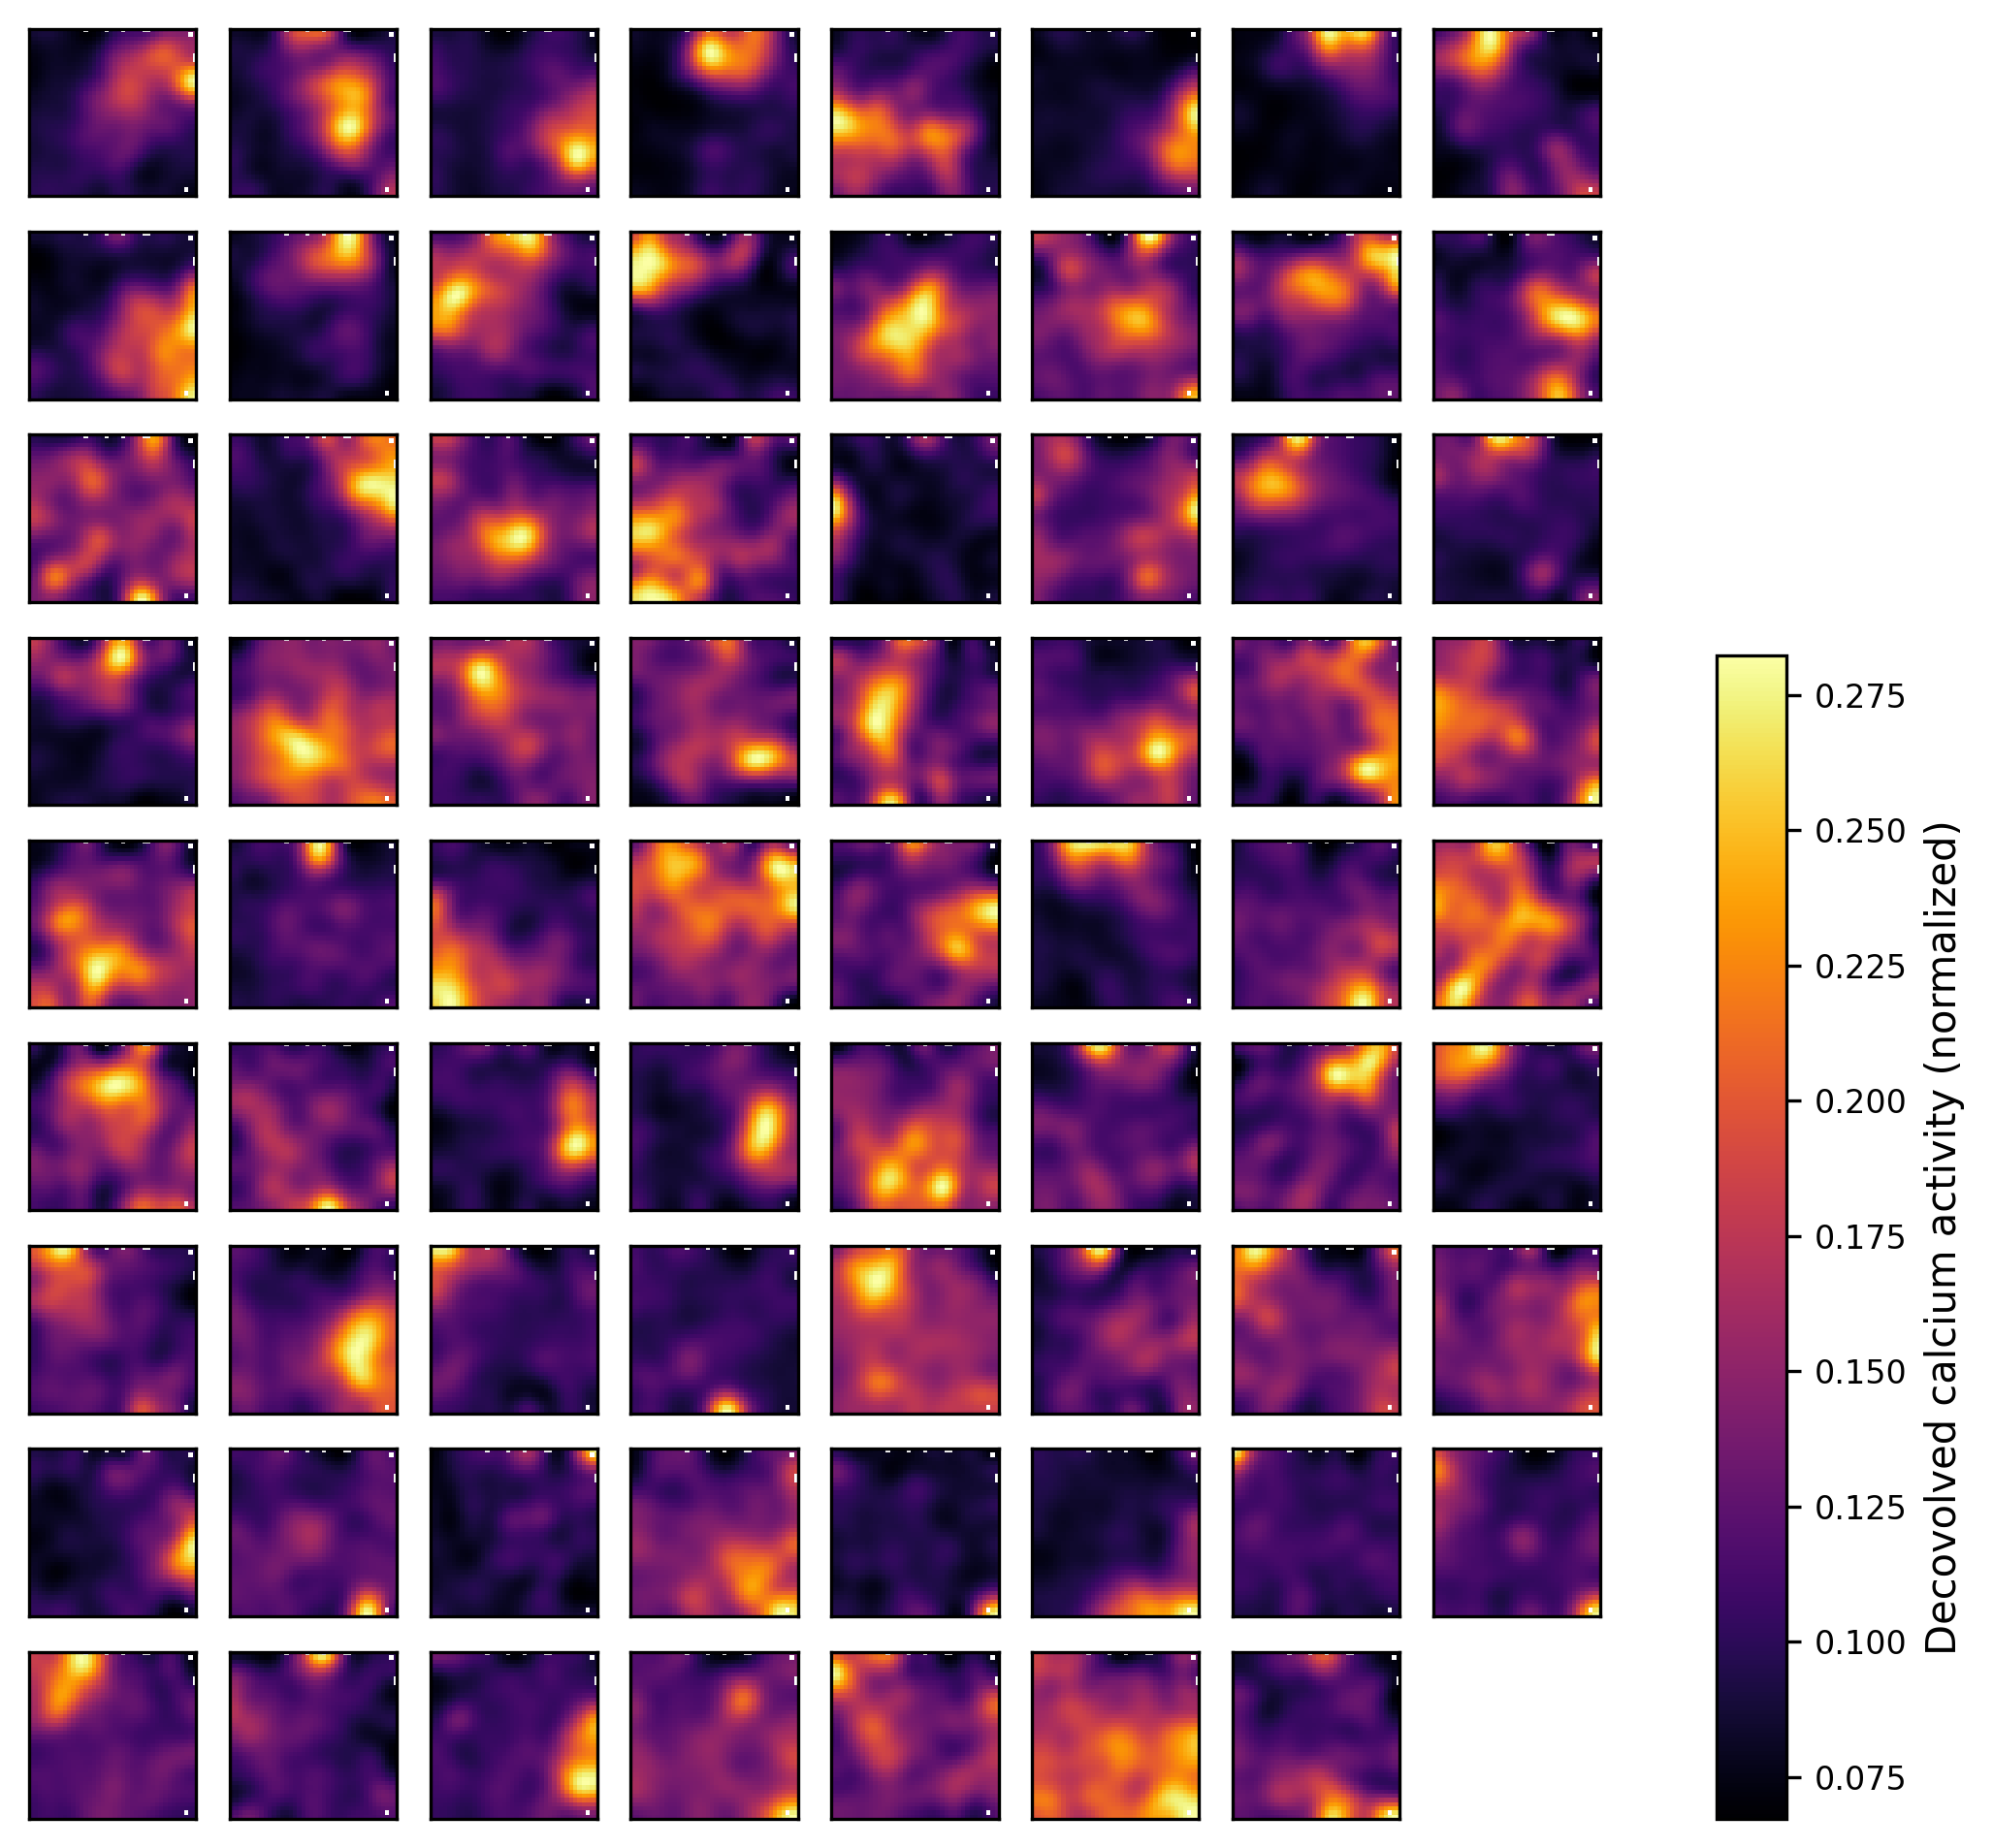

In [44]:
vmin = np.min([np.nanmin(v) for v in valid_maps.values()])
vmax = np.max([np.nanmax(v) for v in valid_maps.values()])

#normalize each map with vmin and vmax
for k, v in valid_maps.items():
    valid_maps[k] = (v-vmin)/(vmax-vmin)


#plot all valid maps in subplots
num = len(valid_maps)
#calculate the number of rows and columns
rows = int(np.ceil(np.sqrt(num)))
cols = int(np.ceil(num/rows))
#
labelsize = 20
ticksize = 8

#set the figure size
plt.figure(figsize=(8,8), dpi=300)

for i, (k, v) in enumerate(valid_maps.items()):
    plt.subplot(rows, cols, i+1)
    plt.imshow(v, cmap='inferno')
    #ticks off
    plt.xticks([]); plt.yticks([])

#add a shared colorbar
plt.subplots_adjust(right=0.8)
#find the bottom of ylim of subplots and align the colorbar with it
bottom = plt.gca().get_position().get_points()[0][1]
cax = plt.axes([0.85, bottom, 0.03, 0.5])
#add colorbar with label size = 10 and tick size = 8
plt.colorbar(cax=cax, label='Decovolved calcium activity (normalized)')
cax.tick_params(labelsize=ticksize)

#save
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P')
plt.savefig(os.path.join(savefolder, 'tuningmaps.pdf'), dpi=300, bbox_inches='tight')




### 4, for selected neurons, plot the firing field in the first half and second half recording

In [52]:
savefolder = os.path.join(datafolder, 'UnrotTiff', '2D2P', 'tuningmaps_halfcompare')
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

labelsize = 10
ticksize = 8

#for each neuron, calculate the tuning map
for i in valid_maps.keys():
    #first one plot the first half data
    fig, axs = plt.subplots(1, 3, figsize=(4, 1.5), dpi=300)
    
    half1_spks_cells = spks[i][timestamps<timestamps[len(timestamps)//2]]
    half1_Traj_x = Traj_x[timestamps<timestamps[len(timestamps)//2]]
    half1_Traj_z = Traj_z[timestamps<timestamps[len(timestamps)//2]]
    half1_timestamps = timestamps[timestamps<timestamps[len(timestamps)//2]]
    
    map1 = getTuningMap(half1_spks_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    img0 = axs[0].imshow(map1, cmap='inferno')
    axs[0].set_title('1st half',  fontsize=labelsize)
    #ticks off
    axs[0].set_xticks([]); axs[0].set_yticks([])
    #add colorbar with the same height as the image
    cbar1 = plt.colorbar(img0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.ax.tick_params(labelsize=ticksize)
    
    #second one plot the second half data
    half2_spks_cells = spks[i][timestamps>=timestamps[len(timestamps)//2]]
    half2_Traj_x = Traj_x[timestamps>=timestamps[len(timestamps)//2]]
    half2_Traj_z = Traj_z[timestamps>=timestamps[len(timestamps)//2]]
    half2_timestamps = timestamps[timestamps>=timestamps[len(timestamps)//2]]
    map2 = getTuningMap(half2_spks_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    img1 = axs[1].imshow(map2, cmap='inferno')
    axs[1].set_title('2nd half', fontsize=labelsize)
    #ticks off
    axs[1].set_xticks([]); axs[1].set_yticks([])
    #add colorbar
    cbar2 = plt.colorbar(img1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar2.ax.tick_params(labelsize=ticksize)
    
    #third one plot the whole data
    map3 = getTuningMap(spks[i], Traj_x, Traj_z, timestamps, VRsize=(1,1),
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting

    img2 = axs[2].imshow(map3, cmap='inferno')
    axs[2].set_title('All', fontsize=labelsize) 
    #ticks off
    axs[2].set_xticks([]); axs[2].set_yticks([])
    #add colorbar
    cbar3 = plt.colorbar(img2, ax=axs[2], fraction=0.046, pad=0.04)
    cbar3.ax.tick_params(labelsize=ticksize)
    #add colobar label
    cbar3.set_label('Deconv', fontsize=ticksize)
    
    plt.tight_layout()
    
    #save the map
    plt.savefig(os.path.join(savefolder, 'firingmap_'+str(i)+'.pdf'), dpi=300)
    plt.close()